# Stage1. Data Processing and Feature Selection

## (a) Data Import

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
#import data from csv file
df = pd.read_csv("../Input/DelayedFlights.csv")
df.shape

(1048575, 30)

In [36]:
df.head(3)

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,0,2008,1,3,4,2003,1955,2211.0,2225,WN,...,4.0,8,0,N,0,NaN,NaN,NaN,NaN,NaN
1,1,2008,1,3,4,754,735,1002.0,1000,WN,...,5.0,10,0,N,0,NaN,NaN,NaN,NaN,NaN
2,2,2008,1,3,4,628,620,804.0,750,WN,...,3.0,17,0,N,0,NaN,NaN,NaN,NaN,NaN


# Exploratory Analysis


#### (a) processing missing value

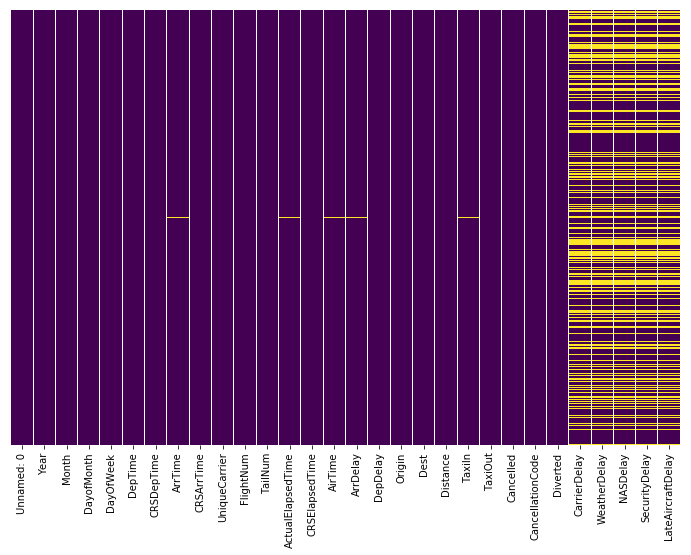

In [37]:
# Yellow is missing values. It is shown in figure that there are many miss values in last 5 columns
plt.figure(figsize = (12, 8))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap="viridis")

In [9]:
# because of too much missing values,which maybe influence the training result, we decide to remove the last 5 column
for column in df.columns[-5:]:
    print("The number of missing values of :%s"%str(column)+" : %d"%df[column].isnull().sum())
    df.drop(column, axis = 1, inplace = True)
# because there are only several rows missing some values, we choose remove it
df.dropna(axis=0, how='any', inplace=True)

The number of missing values of :CarrierDelay : 362841
The number of missing values of :WeatherDelay : 362841
The number of missing values of :NASDelay : 362841
The number of missing values of :SecurityDelay : 362841
The number of missing values of :LateAircraftDelay : 362841


In [39]:
df.head()

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,...,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted
0,0,2008,1,3,4,2003,1955,2211.0,2225,WN,...,-14.0,8,IAD,TPA,810,4.0,8,0,N,0
1,1,2008,1,3,4,754,735,1002.0,1000,WN,...,2.0,19,IAD,TPA,810,5.0,10,0,N,0
2,2,2008,1,3,4,628,620,804.0,750,WN,...,14.0,8,IND,BWI,515,3.0,17,0,N,0
3,4,2008,1,3,4,1829,1755,1959.0,1925,WN,...,34.0,34,IND,BWI,515,3.0,10,0,N,0
4,5,2008,1,3,4,1940,1915,2121.0,2110,WN,...,11.0,25,IND,JAX,688,4.0,10,0,N,0


#### (b) Choose the data of 'WN' UniqueCarrier to do analysis by Delay Rate Of Different Arirlines

In [40]:
#we calculate the rate of all UniqueCarrier,we chose 'WN' that have most instances to do analysis.
uc_count = df.groupby(['UniqueCarrier'],as_index=False)['UniqueCarrier'].agg({'cnt':'count'}).sort_values(by='cnt',ascending=False)
select_UniqueCarrier = uc_count.loc[uc_count['cnt'].idxmax()]['UniqueCarrier']
the_number_of_the_whole_count = uc_count['cnt'].sum()
rate = uc_count.values[:,1]/the_number_of_the_whole_count

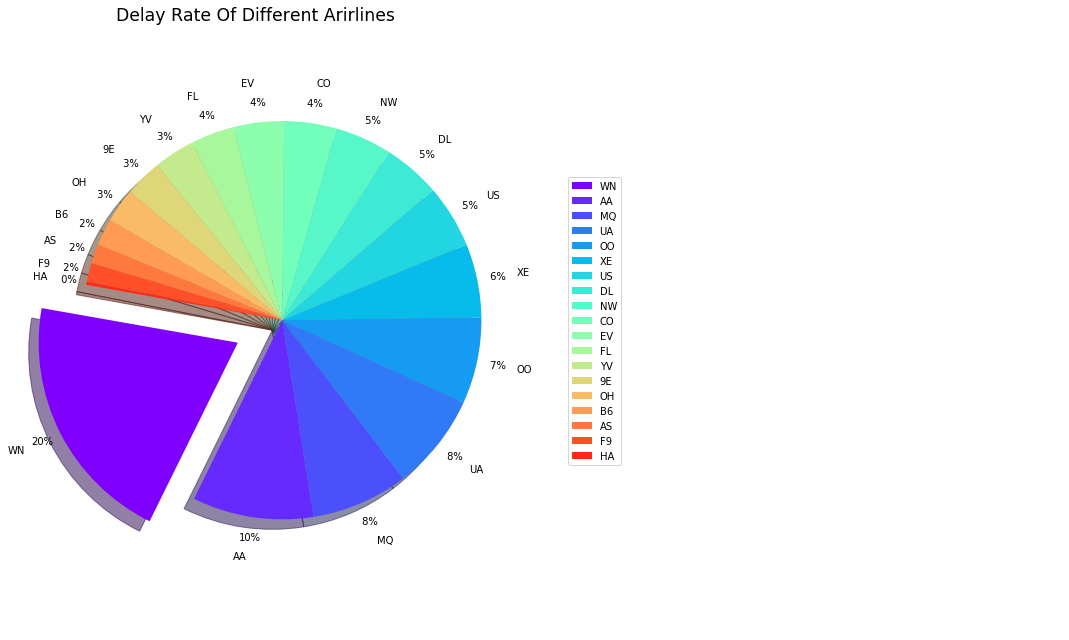

In [41]:
from matplotlib import font_manager as fm
from  matplotlib import cm

labels = uc_count.values[:,0][:-1]
sizes = rate[:-1]
explode = (0.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)  
fig, axes = plt.subplots(figsize=(15,9),ncols=2) 
ax1, ax2 = axes.ravel()
colors = cm.rainbow(np.arange(len(sizes))/len(sizes)) 
patches, texts, autotexts = ax1.pie(sizes, labels=labels, autopct='%2.0f%%',explode=explode,
        shadow=True, startangle=170, colors=colors, labeldistance=1.2,pctdistance=1.1, radius=0.4)
ax1.axis('equal')  
proptease = fm.FontProperties()
proptease.set_size('medium')
plt.setp(autotexts, fontproperties=proptease)
plt.setp(texts, fontproperties=proptease)
ax1.set_title('Delay Rate Of Different Arirlines ', loc='center',fontsize = "xx-large")
ax2.axis('off')
ax2.legend(patches, labels, loc='center left')

plt.tight_layout()
plt.show()

#### (c) use ExtraTreesClassifier to calculate the importance of the features and remove the features with less importance

In [10]:
x = df.copy()
for column in ['Unnamed: 0','CancellationCode','Dest','Origin','UniqueCarrier','TailNum']:
    x.drop(column, axis = 1, inplace = True)
x_values = x.values

In [13]:
y = x_values[:,-7][:20000]
X = np.delete(x_values, -7, axis=1)[:20000]

In [14]:
from sklearn.ensemble import ExtraTreesClassifier
fs_clf = ExtraTreesClassifier(n_estimators=50)
fs_clf = fs_clf.fit(X, y)
fs_clf.feature_importances_

array([0.        , 0.        , 0.05974044, 0.05397162, 0.07422588,
       0.0678337 , 0.07625288, 0.06858085, 0.07202668, 0.07881752,
       0.06168274, 0.0743985 , 0.10243919, 0.07049437, 0.06621888,
       0.07331675, 0.        , 0.        ])

In [22]:
droplist = ['Year','Month','DepTime','CRSDepTime','CRSArrTime','FlightNum',\
            'TailNum','ArrTime','ActualElapsedTime', 'CRSElapsedTime','Cancelled', \
            'CancellationCode', 'Diverted','Unnamed: 0']
for column in droplist:
    df.drop(column, axis = 1, inplace = True)


#### (d) calculate correlation of continious attributes

In [23]:
col = ["TaxiIn","TaxiOut","AirTime","Distance"]
check_cor = df[col]
check_cor.head()

,TaxiIn,TaxiOut,AirTime,Distance
0,4.0,8,116.0,810
1,5.0,10,113.0,810
2,3.0,17,76.0,515
3,3.0,10,77.0,515
4,4.0,10,87.0,688


In [24]:
def get_pairs(df):
    ## Get diagonal and lower triangular pairs of correlation matrix
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=13):
    cal_corr = df.corr().abs().unstack()
    labels_to_drop = get_pairs(df)
    cal_corr = cal_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return cal_corr[0:n]
print(check_cor.corr())
print("Top Absolute Correlations")
print(get_top_abs_correlations(check_cor, 2))

            TaxiIn   TaxiOut   AirTime  Distance
TaxiIn    1.000000  0.068745  0.086427  0.074855
TaxiOut   0.068745  1.000000  0.083562  0.062820
AirTime   0.086427  0.083562  1.000000  0.977847
Distance  0.074855  0.062820  0.977847  1.000000
Top Absolute Correlations
AirTime  Distance    0.977847
TaxiIn   AirTime     0.086427
dtype: float64


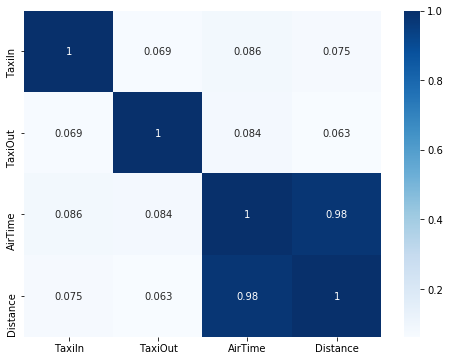

In [25]:
plt.figure(figsize=(8,6))
sns.heatmap(check_cor.corr(),annot=True,cmap="Blues")

In [26]:
df.drop(["AirTime"], axis = 1, inplace = True)

In [30]:
df.head()

,DayofMonth,DayOfWeek,UniqueCarrier,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut
0,3,4,WN,-14.0,8,IAD,TPA,810,4.0,8
1,3,4,WN,2.0,19,IAD,TPA,810,5.0,10
2,3,4,WN,14.0,8,IND,BWI,515,3.0,17
3,3,4,WN,34.0,34,IND,BWI,515,3.0,10
4,3,4,WN,11.0,25,IND,JAX,688,4.0,10


In [31]:
df_filter = df[df['UniqueCarrier']=="WN"]

In [32]:
df_filter.shape

(213885, 10)

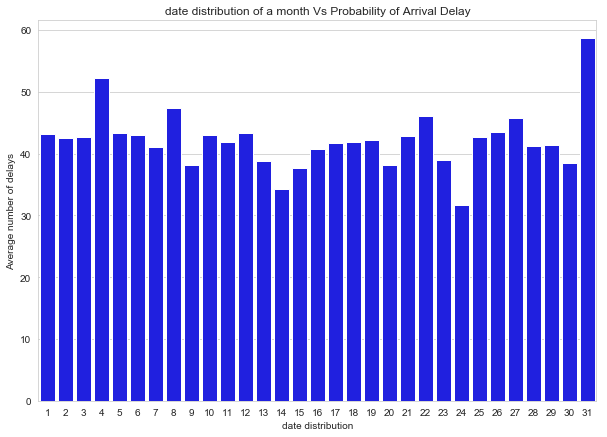

In [48]:
date_grouped = df.groupby('DayofMonth')["ArrDelay"].sum()
date_grouped2 = df.groupby('DayofMonth')["ArrDelay"].count()
Month_grouped = pd.concat([date_grouped, date_grouped2],axis=1, keys=["sum", "count"])
Month_grouped["Average number of delays"] = Month_grouped["sum"]/Month_grouped["count"]
plt.figure(figsize = (10, 7))
sns.set_style('whitegrid')
sns.barplot(x=Month_grouped.index, y ='Average number of delays', data=Month_grouped, color ='blue')
plt.xlabel("date distribution")
plt.ylabel("Average number of delays")
fig = plt.title("date distribution of a month Vs Probability of Arrival Delay")


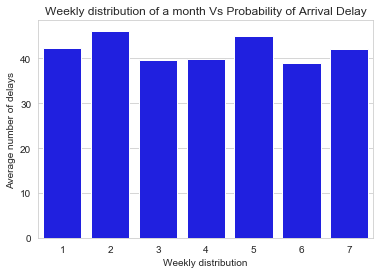

In [50]:
week_grouped = df.groupby('DayOfWeek')["ArrDelay"].sum()
week_grouped2 = df.groupby('DayOfWeek')["ArrDelay"].count()
Week_grouped = pd.concat([week_grouped, week_grouped2],axis=1, keys=["sum", "count"])
Week_grouped["Average number of delays"] = Week_grouped["sum"]/Week_grouped["count"]
plt.figure(figsize = (6, 4))
sns.set_style('whitegrid')
sns.barplot(x=Week_grouped.index, y ='Average number of delays', data=Week_grouped, color ='blue')
plt.xlabel("Weekly distribution")
plt.ylabel("Average number of delays")
fig = plt.title("Weekly distribution of a month Vs Probability of Arrival Delay")

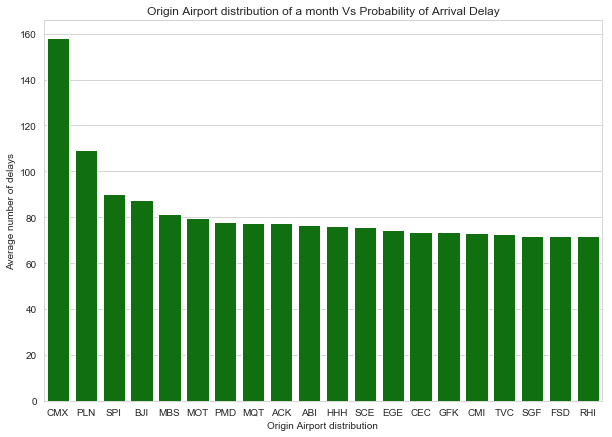

In [52]:
origin_grouped = df.groupby('Origin')["ArrDelay"].sum()
origin_grouped2 = df.groupby('Origin')["ArrDelay"].count()
Origin_grouped = pd.concat([origin_grouped, origin_grouped2],axis=1, keys=["sum", "count"])
Origin_grouped["Average number of delays"] = Origin_grouped["sum"]/Origin_grouped["count"]
Origin_grouped.sort_values(by = "Average number of delays", ascending = False, inplace = True)
plt.figure(figsize = (10, 7))
sns.set_style('whitegrid')
sns.barplot(x=Origin_grouped.index[:20], y ='Average number of delays', data=Origin_grouped[:20], color ='green')
plt.xlabel("Origin Airport distribution")
plt.ylabel("Average number of delays")
fig = plt.title("Origin Airport distribution of a month Vs Probability of Arrival Delay")

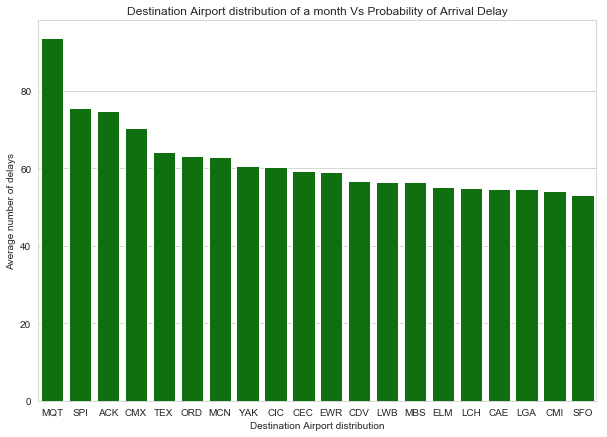

In [53]:
des_grouped = df.groupby('Dest')["ArrDelay"].sum()
des_grouped2 = df.groupby('Dest')["ArrDelay"].count()
Des_grouped = pd.concat([des_grouped, des_grouped2],axis=1, keys=["sum", "count"])
Des_grouped["Average number of delays"] = Des_grouped["sum"]/Des_grouped["count"]
Des_grouped.sort_values(by = "Average number of delays", ascending = False, inplace = True)
plt.figure(figsize = (10,7))
sns.set_style('whitegrid')
sns.barplot(x=Des_grouped.index[:20], y ='Average number of delays', data=Des_grouped[:20], color ='green')
plt.xlabel("Destination Airport distribution")
plt.ylabel("Average number of delays")
fig = plt.title("Destination Airport distribution of a month Vs Probability of Arrival Delay")

#### (e) encoding 'Origin' and 'Dest' columns to one-hot vector

In [33]:
categories = ['Origin', 'Dest']
indicator_var = pd.DataFrame()
for i in categories:
    x = pd.get_dummies(df_filter[i],drop_first=True)
    indicator_var = pd.concat([indicator_var, x],axis=1)
df_filter2 = df_filter.drop('UniqueCarrier', axis = 1, inplace = True)

/anaconda2/envs/python_3_6/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [34]:
df_filter.head()

,DayofMonth,DayOfWeek,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut
0,3,4,-14.0,8,IAD,TPA,810,4.0,8
1,3,4,2.0,19,IAD,TPA,810,5.0,10
2,3,4,14.0,8,IND,BWI,515,3.0,17
3,3,4,34.0,34,IND,BWI,515,3.0,10
4,3,4,11.0,25,IND,JAX,688,4.0,10


In [35]:
#drop the the columns which use one - hot to encode
for col in categories:
    df_filter.drop(col, axis = 1, inplace = True)


#### (e) combine the data

In [13]:
final_data = pd.concat([indicator_var, df_filter],axis=1)


In [14]:
final_data.shape

(213885, 133)

In [15]:
final_data.head()
final_data_filter_values = final_data.values

In [16]:
print(final_data_filter_values)

[[   0.    0.    0. ...  810.    4.    8.]
 [   0.    0.    0. ...  810.    5.   10.]
 [   0.    0.    0. ...  515.    3.   17.]
 ...
 [   0.    0.    0. ... 1372.    5.    9.]
 [   0.    0.    0. ...  237.    4.    9.]
 [   0.    0.    0. ...  880.    5.   12.]]


In [17]:
label_array = final_data_filter_values[:,-5]
features_array = np.delete(final_data_filter_values, -5, axis=1)



# Stage2. Model Buidling

In [37]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import learning_curve, GridSearchCV,train_test_split
from sklearn.neural_network import MLPRegressor  
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
import time
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold




In [38]:
#Pca --- dimensionality reduction
def PCA_transform(n_components,x):
    pca = PCA(n_components)
    x_Pca = pca.fit_transform(x) 
    return x_Pca

In [39]:
# Nomalization
scaler = StandardScaler() 
scaler.fit(features_array)  
features_array_norm = scaler.transform(features_array)


In [40]:
#split data to train_data(80%) and test_data(20%) 
train_data,test_data,train_label,test_label = train_test_split(features_array_norm,label_array,train_size=0.8)

/anaconda2/envs/python_3_6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [29]:
# 10 - fold cross validation, This method is used to adjust parameters by mse.
def ten_flod_cv(clf,X,y,cv = 10):
    t1 = time.time()
    scores_mse = cross_val_score(clf, X, y, scoring = 'neg_mean_squared_error',cv=10)
    print("MSE : %3f"%(scores_mse.mean()))
    t2 = time.time()
    print("time : %3f"%((t2-t1)/cv))
    return(abs(scores_mse))


# Method1.Multilayer Perceptron Regression

#### (1).adjust alpha and max_iter --- result : choose alpha = 0.01 ,max_iter = 300

In [62]:
scores = []
for max_iter in [50,100,200,300,400,500]:
#     for alpha in [0.0001,0.001,0.01]:
    for alpha in [0.1,0.05]:


        mlpclf = MLPRegressor(solver='lbfgs', max_iter = max_iter,alpha=alpha,hidden_layer_sizes=(10, 10), random_state=1)
        print("max_iter :" + str(max_iter)+", alpha : "+str(alpha)+" : ")
        scores.append((abs(ten_flod_cv(mlpclf,train_data,train_label)),max_iter,alpha))

max_iter :50, alpha : 0.1 : 
MSE : -135.589906
time : 3.003607
max_iter :50, alpha : 0.05 : 
MSE : -134.986410
time : 3.024354
max_iter :100, alpha : 0.1 : 
MSE : -91.501799
time : 5.954902
max_iter :100, alpha : 0.05 : 
MSE : -91.416047
time : 5.978404
max_iter :200, alpha : 0.1 : 
MSE : -75.548941
time : 12.207243
max_iter :200, alpha : 0.05 : 
MSE : -75.278762
time : 12.103102
max_iter :300, alpha : 0.1 : 
MSE : -70.448707
time : 18.107810
max_iter :300, alpha : 0.05 : 
MSE : -70.323403
time : 18.048943
max_iter :400, alpha : 0.1 : 
MSE : -68.333051
time : 24.059764
max_iter :400, alpha : 0.05 : 
MSE : -68.113061
time : 23.153831
max_iter :500, alpha : 0.1 : 
MSE : -67.012524
time : 28.572835
max_iter :500, alpha : 0.05 : 
MSE : -66.946341
time : 28.609612


#### (2).adjust hidden layer size --- result : (30,30)

In [66]:
scores = []
for hidden_layer_size in [(10,10),(20,20),(30,30),(10,10,10),(20,20,20),(30,30,30),(10,10,10,10),(20,20,20,20)]:
    mlpclf = MLPRegressor(solver='lbfgs',max_iter = 300,alpha=0.05,hidden_layer_sizes=hidden_layer_size, random_state=1)
    print("hidden_layer_sizes :" + str(hidden_layer_size))
    scores.append((abs(ten_flod_cv(mlpclf,train_data,train_label)),hidden_layer_size))

hidden_layer_sizes :(10, 10)
MSE : -70.323403
time : 17.308037
hidden_layer_sizes :(20, 20)
MSE : -62.784153
time : 29.362903
hidden_layer_sizes :(30, 30)
MSE : -61.224164
time : 43.249871
hidden_layer_sizes :(10, 10, 10)
MSE : -71.969470
time : 24.290883
hidden_layer_sizes :(20, 20, 20)
MSE : -63.355819
time : 42.722778
hidden_layer_sizes :(30, 30, 30)
MSE : -60.958309
time : 61.858682
hidden_layer_sizes :(10, 10, 10, 10)
MSE : -67.262907
time : 29.137480
hidden_layer_sizes :(20, 20, 20, 20)
MSE : -62.661361
time : 52.717707


# Method2. Gradient Boosting Regressor

#### (1). adjust n_estimators -- result: choose n_estimators = 120 

In [27]:
from sklearn.ensemble import GradientBoostingRegressor
scores = []
for i in range(3,7):
    est = GradientBoostingRegressor(n_estimators=20*i, learning_rate=0.1,max_depth=1, random_state=0, loss='ls').fit(train_data, train_label)
    print("n_estimators :" + str(20*i)+" : ")
    scores.append((abs(ten_flod_cv(est,train_data,train_label)),20*i))


n_estimators :60 : 
MSE : -1310.005551
time : 28.270602
n_estimators :80 : 
MSE : -1249.734488
time : 33.843373
n_estimators :100 : 
MSE : -1200.719536
time : 44.895866
n_estimators :120 : 
MSE : -1159.507526
time : 52.210772


# Method3. Gradient Boosting Regressor

#### (1) adjust the C and kernel(because the speed is too slow we use the smaller data to adjust paramaters) -- result : C = 1.2,kernel = 'linear' 

In [26]:
scores = []
for C in [0.8,0.9,1.0,1.1,1.2]:
    for kernel in ["rbf","linear","poly"]:
        SVRclf = SVR(C=C,kernel = kernel)
        print("C :" + str(C)+", kernel : "+str(kernel)+" : ")

        scores.append((ten_flod_cv(SVRclf,train_data[:10000],train_label[:10000]),C,kernel))

C :0.8, kernel : rbf : 


/anaconda2/envs/python_3_6/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda2/envs/python_3_6/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda2/envs/python_3_6/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda2/envs/python_3_6/lib/python3.6/si

MSE : -1442.242267
time : 8.139232
C :0.8, kernel : linear : 
MSE : -907.998949
time : 8.067075
C :0.8, kernel : poly : 


/anaconda2/envs/python_3_6/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda2/envs/python_3_6/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda2/envs/python_3_6/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda2/envs/python_3_6/lib/python3.6/si

MSE : -1737.901048
time : 6.781206
C :0.9, kernel : rbf : 


/anaconda2/envs/python_3_6/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda2/envs/python_3_6/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda2/envs/python_3_6/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda2/envs/python_3_6/lib/python3.6/si

MSE : -1398.050981
time : 7.975986
C :0.9, kernel : linear : 
MSE : -907.591956
time : 8.018172
C :0.9, kernel : poly : 


/anaconda2/envs/python_3_6/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda2/envs/python_3_6/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda2/envs/python_3_6/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda2/envs/python_3_6/lib/python3.6/si

MSE : -1708.919521
time : 6.547465
C :1.0, kernel : rbf : 


/anaconda2/envs/python_3_6/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda2/envs/python_3_6/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda2/envs/python_3_6/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda2/envs/python_3_6/lib/python3.6/si

MSE : -1356.896032
time : 8.008214
C :1.0, kernel : linear : 
MSE : -907.363726
time : 8.200865
C :1.0, kernel : poly : 


/anaconda2/envs/python_3_6/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda2/envs/python_3_6/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda2/envs/python_3_6/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda2/envs/python_3_6/lib/python3.6/si

MSE : -1680.631492
time : 6.745852
C :1.1, kernel : rbf : 


/anaconda2/envs/python_3_6/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda2/envs/python_3_6/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda2/envs/python_3_6/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda2/envs/python_3_6/lib/python3.6/si

MSE : -1320.372070
time : 8.104538
C :1.1, kernel : linear : 
MSE : -907.145538
time : 8.349136
C :1.1, kernel : poly : 


/anaconda2/envs/python_3_6/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda2/envs/python_3_6/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda2/envs/python_3_6/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda2/envs/python_3_6/lib/python3.6/si

MSE : -1652.932430
time : 6.794153
C :1.2, kernel : rbf : 


/anaconda2/envs/python_3_6/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda2/envs/python_3_6/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda2/envs/python_3_6/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda2/envs/python_3_6/lib/python3.6/si

MSE : -1285.346803
time : 7.911624
C :1.2, kernel : linear : 
MSE : -907.053449
time : 8.461773
C :1.2, kernel : poly : 


/anaconda2/envs/python_3_6/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda2/envs/python_3_6/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda2/envs/python_3_6/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda2/envs/python_3_6/lib/python3.6/si

MSE : -1625.872772
time : 6.625516


In [28]:
for x,y,z in scores:
    print(x)
    print(y)
    print(z)




[1155.4596852  1525.15265912 1547.40511935 1651.19150351 1627.09476707
 1516.30810841 1465.11221555 1029.89529864 1451.23900217 1453.56430843]
0.8
rbf
[ 806.88789737  973.00455247  944.45209333 1020.94790825 1012.79864101
  938.34169523  896.4034229   715.98170812  926.6874029   844.4841685 ]
0.8
linear
[1519.81251981 1898.32572818 1833.53419786 1977.59798502 1966.62564531
 1830.93058314 1719.67552564 1327.68465472 1670.12196499 1634.70167399]
0.8
poly
[1113.29665098 1473.26467545 1503.33960304 1602.28801919 1575.88059476
 1468.51868595 1423.0844941   992.72355025 1411.41949994 1416.6940401 ]
0.9
rbf
[ 806.82372701  971.67651086  944.23299126 1020.50016842 1012.2163902
  937.86097805  896.39919163  715.80975201  926.3387536   844.06109854]
0.9
linear
[1498.7817146  1870.15919332 1802.41544244 1942.58195779 1931.48849393
 1801.80367757 1690.53535745 1308.85770384 1640.33094997 1602.24072149]
0.9
poly
[1073.19200463 1425.75655354 1463.0101405  1555.60796039 1527.35914279
 1424.04610539 1

# Stage3. Choosing Model and Save Model --- Compare the performance


In [22]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error 
import math
import time
from sklearn.ensemble import GradientBoostingRegressor
import pickle

In [23]:
# the method to calculate Negative Log Likelihood for the predictions(NLL)
def n_log_less(y_true,y_pred):
    y_pred_mean = y_pred.mean()
    y_sqrt = np.sum((y_pred-y_true)**2)
    log_likelihood_elements = (0.5*np.log(2*math.pi*y_sqrt))+np.sum((y_true -y_pred_mean)**2)/(2*y_sqrt)
    return log_likelihood_elements



In [24]:
# use 10 - fold to train model with train data(80% the whole data) 
# and calculate MSE and NLL as the performances of the train model
def ten_fold_cv_mse_nll(clf,X,Y):
    stratified_folder = StratifiedKFold(n_splits=10, random_state=0, shuffle=False)
    nll_list = []
    mse_list = []
    timelist = []
    for train_index, test_index in stratified_folder.split(X, Y):


        X_train = X[train_index]
        Y_train = Y[train_index]
        X_test = X[test_index]
        Y_test = Y[test_index]

        t1 = time.time()
        clf.fit(X_train,Y_train)
        pre_Result = clf.predict(X_test)
        t2 = time.time()



        print("++++++++++++++++")
        print("MSE : %2f"%(mean_squared_error(Y_test,pre_Result)))
        print("NLL : %2f"%(n_log_less(Y_test,pre_Result)))
        nll_list.append(n_log_less(Y_test,pre_Result))
        mse_list.append(mean_squared_error(Y_test,pre_Result))
        print("TIME : %2f"%(t2-t1))
        timelist.append(t2-t1)
    return mse_list,nll_list,clf,timelist


### (a) calculate the performance of MLPRegressor and save the model

In [26]:
mlpclf = MLPRegressor(solver='lbfgs',max_iter = 300,alpha=0.01,hidden_layer_sizes=(30,30), random_state=1)
mse_list,nll_list,mlpclf,timelist = ten_fold_cv_mse_nll(mlpclf,train_data,train_label)



/anaconda2/envs/python_3_6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


++++++++++++++++
MSE : 62.027546
NLL : 27.714771
TIME : 43.577597
++++++++++++++++
MSE : 62.701126
NLL : 24.097252
TIME : 40.958536
++++++++++++++++
MSE : 58.205477
NLL : 23.185363
TIME : 40.661025
++++++++++++++++
MSE : 58.088582
NLL : 22.335784
TIME : 42.510786
++++++++++++++++
MSE : 59.187653
NLL : 21.216306
TIME : 44.073593
++++++++++++++++
MSE : 58.388296
NLL : 21.061278
TIME : 40.893892
++++++++++++++++
MSE : 60.034643
NLL : 20.359676
TIME : 41.242609
++++++++++++++++
MSE : 60.077691
NLL : 19.771272
TIME : 41.344134
++++++++++++++++
MSE : 61.732235
NLL : 19.132382
TIME : 40.619898
++++++++++++++++
MSE : 58.069273
NLL : 19.475609
TIME : 42.414659


In [27]:
print("--------------------------MLP RESULT--------------------------")
print("MSE : %2f"%(sum(mse_list)/len(mse_list)))
print("NLL : %2f"%(sum(nll_list)/len(nll_list)))
print("TIME : %2f"%(sum(timelist)/len(timelist)))

--------------------------MLP RESULT--------------------------
MSE : 59.851252
NLL : 21.834969
TIME : 41.829673


In [28]:
# save this model### (a) calculate the performance of MLPRegressor and save the model
filename='mlp-model.sav'
pickle.dump(mlpclf, open(filename, 'wb'))

In [29]:
filename='mlp-model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(test_data, test_label)
print(result)


0.9650199902204663


### (b) calculate the performance of Gradient Boosting Regressor and save the model

In [30]:
est_clf = GradientBoostingRegressor(n_estimators=120, learning_rate=0.1,max_depth=1, random_state=0, loss='ls')
mse_list_gbr,nll_list_gbr,gbrclf,timelist_gbr = ten_fold_cv_mse_nll(est_clf,train_data,train_label)

/anaconda2/envs/python_3_6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


++++++++++++++++
MSE : 142.579954
NLL : 16.916191
TIME : 25.834553
++++++++++++++++
MSE : 97.983503
NLL : 18.476028
TIME : 28.641484
++++++++++++++++
MSE : 87.068713
NLL : 18.295573
TIME : 26.172146
++++++++++++++++
MSE : 87.858158
NLL : 17.625981
TIME : 25.541673
++++++++++++++++
MSE : 86.452728
NLL : 17.185048
TIME : 25.656962
++++++++++++++++
MSE : 86.135515
NLL : 16.991938
TIME : 26.016605
++++++++++++++++
MSE : 91.670799
NLL : 16.250030
TIME : 26.077824
++++++++++++++++
MSE : 87.413907
NLL : 16.226823
TIME : 26.101367
++++++++++++++++
MSE : 88.142213
NLL : 15.929894
TIME : 26.328866
++++++++++++++++
MSE : 83.777336
NLL : 16.081578
TIME : 26.095878


In [31]:
print("--------------------------GBR RESULT--------------------------")
print("MSE : %2f"%(sum(mse_list_gbr)/len(mse_list_gbr)))
print("NLL : %2f"%(sum(nll_list_gbr)/len(nll_list_gbr)))
print("TIME : %2f"%(sum(timelist_gbr)/len(timelist_gbr)))

--------------------------GBR RESULT--------------------------
MSE : 93.908283
NLL : 16.997908
TIME : 26.246736


In [47]:
filename='gbr-model.sav'
pickle.dump(gbrclf, open(filename, 'wb'))

### (c) calculate the performance of Support Vector Regression and Save the Model

In [ ]:
SVRclf = SVR(C=1.2,kernel = 'linear')
mse_list_svr,nll_list_svr,svrclf,timelist_svr = ten_fold_cv_mse_nll(SVRclf,train_data,train_label)

/anaconda2/envs/python_3_6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


++++++++++++++++
64.77901920261024
26.81163528325742
13187.760407924652


# Stage4. Load Model and predict the test data 

In [1]:
import numpy as np
import pandas as pd
import time
from sklearn.metrics import mean_squared_error 
import math
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("../Input/DelayedFlights.csv")# because of too much missing values,which maybe influence the training result, we decide to remove the last 5 column
for column in df.columns[-5:]:
    print("The number of missing values of :%s"%str(column)+" : %d"%df[column].isnull().sum())
    df.drop(column, axis = 1, inplace = True)
# because there are only several rows missing some values, we choose remove it
df.dropna(axis=0, how='any', inplace=True)
droplist = ['Year','Month','DepTime','CRSDepTime','CRSArrTime','FlightNum',\
            'TailNum','ActualElapsedTime', 'CRSElapsedTime','Cancelled', \
            'CancellationCode', 'Diverted','Unnamed: 0']
for column in droplist:
    df.drop(column, axis = 1, inplace = True)
df.drop(["AirTime"], axis = 1, inplace = True)
df.drop(["ArrTime"], axis = 1, inplace = True)
df_filter = df[df['UniqueCarrier']=="WN"]
categories = ['Origin', 'Dest']
indicator_var = pd.DataFrame()
for i in categories:
    x = pd.get_dummies(df_filter[i],drop_first=True)
    indicator_var = pd.concat([indicator_var, x],axis=1)
df_filter.drop('UniqueCarrier', axis = 1, inplace = True)
for col in categories:
    df_filter.drop(col, axis = 1, inplace = True)
final_data = pd.concat([indicator_var, df_filter],axis=1)
final_data_filter_values = final_data.values
label_array = final_data_filter_values[:,-5]
features_array = np.delete(final_data_filter_values, -5, axis=1)
# Nomalization
scaler = StandardScaler() 
scaler.fit(features_array)  
features_array_norm = scaler.transform(features_array)
train_data,test_data,train_label,test_label = train_test_split(features_array_norm,label_array,train_size=0.8)
print("train dataset size : " + str(np.shape(train_data)))
print("test dataset size : " + str(np.shape(test_data)))

The number of missing values of :CarrierDelay : 362841
The number of missing values of :WeatherDelay : 362841
The number of missing values of :NASDelay : 362841
The number of missing values of :SecurityDelay : 362841
The number of missing values of :LateAircraftDelay : 362841


/anaconda2/envs/python_3_6/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/anaconda2/envs/python_3_6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


train dataset size : (171108, 132)
test dataset size : (42777, 132)


In [3]:
# the method to calculate Negative Log Likelihood for the predictions(NLL)
def n_log_less(y_true,y_pred):
    y_pred_mean = y_pred.mean()
    y_sqrt = np.sum((y_pred-y_true)**2)
    log_likelihood_elements = (0.5*np.log(2*math.pi*y_sqrt))+np.sum((y_true -y_pred_mean)**2)/(2*y_sqrt)
    return log_likelihood_elements

## Best model is MLPREGRESSOR

In [4]:
filename='mlp-model.sav'
mlpmodel = pickle.load(open(filename, 'rb'))
pre_result =mlpmodel.predict(test_data) 
print("--------------------------MLP RESULT--------------------------")
print("MSE : %2f"%(mean_squared_error(test_label,pre_result)))
print("NLL : %2f"%(n_log_less(test_label,pre_result)))

--------------------------MLP RESULT--------------------------
MSE : 57.209422
NLL : 22.929275


In [5]:
filename='gbr-model.sav'
gbrmodel = pickle.load(open(filename, 'rb'))
pre_result =gbrmodel.predict(test_data) 
print("--------------------------GBR RESULT--------------------------")
print("MSE : %2f"%(mean_squared_error(test_label,pre_result)))
print("NLL : %2f"%(n_log_less(test_label,pre_result)))

--------------------------GBR RESULT--------------------------
MSE : 89.712932
NLL : 17.921759


In [6]:
# this model is too big and slow even we have already save the model
filename='svr-model.sav'
svrmodel = pickle.load(open(filename, 'rb'))
pre_result =svrmodel.predict(test_data) 
print("--------------------------svr RESULT--------------------------")
print("MSE : %2f"%(mean_squared_error(test_label,pre_result)))
print("NLL : %2f"%(n_log_less(test_label,pre_result)))

--------------------------svr RESULT--------------------------
MSE : 63.524467
NLL : 21.635543
